In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import qutip as qt
import math as math
from qutip.qip.operations import hadamard_transform
from functools import reduce



# Grovers Algorithm 
## Introduction

Time complexity is a representation of the time taken by an algorithm to solve a problem as a function relative to the size of the input data. This property is commonly expressed in $\mathcal{O}$ ("Big O") notation which represents the upper bound of the number of steps needed to solve the problem.

If you have $N$ randomly ordered elements and you need to find a particular element, in classical computing the time complexity is $\mathcal{O}(N)$.

In the context of quantum computing, Grover's algorithm seeks to find a particular element with $\mathcal{O}(\sqrt{N})$ time complexity. The decreased time complexity is due to the superposition of states, which allows for simultaneous examination of multiple elements.

This report aims to examine Grovers Algorithm and create an executable demo using 'qutip' (Quantum Toolbox in Python)

by Jessie Lonsdale and Anastasios Mavridis.

In [2]:
def generate_search_problem(length):
    haystack = '0' * int(math.pow(2,length))
    needle = np.random.randint(0,int(math.pow(2,length))-1)
    return (haystack[:needle]+'1'+haystack[needle + 1:]), needle

In [3]:
def grovers_circuit(haystack,needle):
    
    # Calculate the number of qubits needed to represent this problem
    string_length = int(len(haystack))
    number_of_qubits = int(math.log(string_length, 2))
    
    # Initialize data qubits using list comprehension
    qubits = [qt.basis(2, 0) for _ in range(number_of_qubits)]

    # Add control qubit
    qubits.append(qt.basis(2, 1))

    # Calculate tensor product of input operators to create the initial state Q:
    Q = qt.tensor(qubits)
    
    # Apply tensor product to a list of Hadamard transform operations
    H = reduce(lambda x, y: qt.tensor(x, y), [hadamard_transform(1) for _ in range(len(qubits))])
    
    # Begin with applying H to Q
    current_state = H * Q
            
    ##########################
    # Phase Shifting Gate Uf #
    ##########################
    
    # create a matrix that phase shifts only the target element (position of '1')
    
    Uf = np.zeros((string_length*2, string_length*2))
    for i, q in enumerate(haystack):
        print
        if q == '0':
            Uf[2*i:2*i+2, 2*i:2*i+2] = np.array([[1, 0], [0, 1]])
        else:
            Uf[2*i:2*i+2, 2*i:2*i+2] = np.array([[0, 1], [1, 0]])
        
    # create HxI, CxZI and XxI gates
    HxI_gates = [hadamard_transform(1) for _ in range(len(qubits)-1)]
    HxI_gates.append(qt.qeye(2))
    HxI = qt.tensor(HxI_gates)

    XxI_gates = [qt.sigmax() for _ in range(len(qubits)-1)]
    XxI_gates.append(qt.qeye(2))
    XxI = qt.tensor(XxI_gates)

    CxZI = np.zeros([string_length,string_length])
    for i in range(int(string_length-1)):
        CxZI[i,i] = 1
    CxZI[string_length-1,string_length-1] = -1
    CxZI = qt.tensor(qt.Qobj(CxZI), qt.qeye(2))
    CxZI.dims = HxI.dims

    # Diffusion operator
    Dif = HxI * XxI * CxZI * XxI * HxI

    # Now repeat Uf and Dif <repeat> times.  This is the Grover Iteration.
    for i in range(int((math.pi/4) * math.sqrt(2**(number_of_qubits)))):
        current_state = Uf * current_state
        current_state = Dif * current_state
        current_state = qt.Qobj(current_state)
    return current_state


Logging results & performance from n=2 to n=9
For the problem n = 2 & haystack_size = 4
Needle position from Grover's algorithm: 0
True needle position: 0
Success! Grovers algorithm has found the correct position.
For the problem n = 3 & haystack_size = 8
Needle position from Grover's algorithm: 3
True needle position: 3
Success! Grovers algorithm has found the correct position.
For the problem n = 4 & haystack_size = 16
Needle position from Grover's algorithm: 0
True needle position: 0
Success! Grovers algorithm has found the correct position.
For the problem n = 5 & haystack_size = 32
Needle position from Grover's algorithm: 7
True needle position: 7
Success! Grovers algorithm has found the correct position.
For the problem n = 6 & haystack_size = 64
Needle position from Grover's algorithm: 30
True needle position: 30
Success! Grovers algorithm has found the correct position.
For the problem n = 7 & haystack_size = 128
Needle position from Grover's algorithm: 3
True needle position: 

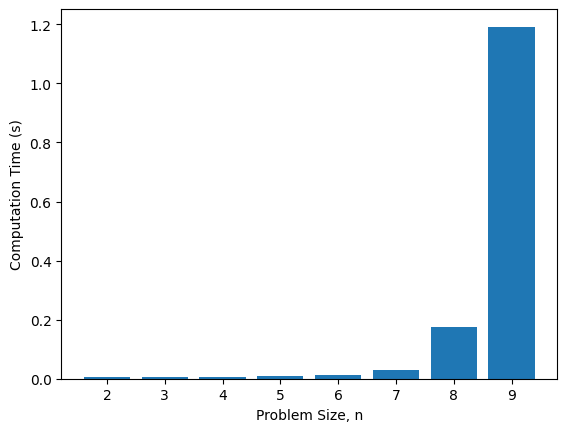

In [4]:
print("=" * 60)
print('Logging results & performance from n=2 to n=9')
computation_times = []
for n in range(2, 10):
    haystack, needle = generate_search_problem(n)
    start_time = time.time()
    current_state = np.array(grovers_circuit(haystack, needle))
    end_time = time.time()
    result = []
    for i in range(0, len(current_state), 2):
        result.append((abs(current_state[i]) + abs(current_state[i+1]))[0])       
    needlePosFromResults = np.argmax(result)
    computation_time = end_time - start_time
    computation_times.append(computation_time)
    print("=" * 60)
    print(f"For the problem n = {n} & haystack_size = {len(haystack)}")
    print(f"Needle position from Grover's algorithm: {needlePosFromResults}")
    print(f"True needle position: {needle}")
    if needle == needlePosFromResults:
        print("Success! Grovers algorithm has found the correct position.")
    else:
        print("Failure, Grovers algorithm has found an incorrect position.")
    print("=" * 60)


plt.bar(range(2, 10), computation_times)
plt.xlabel('Problem Size, n')
plt.ylabel('Computation Time (s)')
plt.show()